In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import arviz as az

In [2]:
data_path = "data/Retail_Sales_Data.csv"
df = pd.read_csv(data_path)
df.head()

,retailer,store_id,week,product,description,regular_price,competition_1_regular_price,competition_2_regular_price,competition_3_regular_price,competition_4_regular_price,...,competition_4_promo_price,competition_5_promo_price,competition_6_promo_price,competition_7_promo_price,competition_8_promo_price,competition_9_promo_price,competition_10_promo_price,value,volume,quantity
0,retail1,1,1,MintyFresh Mint 18g,MintyFresh refresh mint 18grams,10.308645,10.624815,10.013451,10.378847,9.910385,...,8.500521,7.139537,7.606831,8.339536,7.184384,5.759620,7.376553,85.368310,3.953882,9.707949
1,retail1,1,1,ChocoDelight Dark 200g,200g ChocoDelight smooth,7.947956,7.748726,7.589198,8.085262,7.602363,...,5.766135,4.267236,5.912718,5.156558,6.976287,5.884786,5.335849,82.924731,2.991418,14.922586
2,retail1,1,1,ChocoDelight White 350g,350g ChocoDelight delicious,13.439368,13.751508,13.183621,13.875440,12.982707,...,8.195118,8.214548,8.995387,10.266603,10.940801,8.727031,7.915147,52.527762,6.513600,12.889607
3,retail1,1,1,NuttyCream Hazelnuts 80g,delightful Hazelnuts 80g NuttyCream,5.112777,5.279713,5.222118,5.117789,4.877549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.373782,5.489587,14.374834
4,retail1,1,1,DarkDream Dark 60g,A decadent DarkDream dark chocolate ice cream ...,14.085425,14.153721,13.860002,14.339698,14.365517,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.718252,9.152050,9.193818


In [3]:
# Data for retailer 2
df_retailer2 = df[df['retailer'] == 'retail2']

In [4]:
# Features from the pooled model
features = ['regular_price', 'value', 'volume']

In [5]:
# Splitting data into features and target
X = df_retailer2[features].values
y = df_retailer2['quantity'].values

In [6]:
# Create a training and testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print("Training Data Shape:", X_train.shape, y_train.shape)
print("Testing Data Shape:", X_test.shape, y_test.shape)

Training Data Shape: torch.Size([2912, 3]) torch.Size([2912])
Testing Data Shape: torch.Size([728, 3]) torch.Size([728])


In [7]:
# Adding a column of ones to X for the intercept term
X_train_with_intercept = torch.cat((torch.ones(X_train.shape[0], 1), X_train), dim=1)
X_test_with_intercept = torch.cat((torch.ones(X_test.shape[0], 1), X_test), dim=1)

In [8]:
# Setting the priors
beta_ols = torch.tensor([4.89162135, -0.03719734,  0.10207052,  0.1855003])
sigma_ols = torch.tensor(2.8731253225417834)

In [9]:
# Bayesian model
def model(X, y=None):
    # Using the coefficients from the pooled OLS model as priors
    beta = pyro.sample('beta', dist.Normal(beta_ols, torch.ones_like(beta_ols)))  # Priors with OLS means
    sigma = pyro.sample('sigma', dist.HalfNormal(sigma_ols))
    
    mu = torch.matmul(X, beta)
    with pyro.plate('data', X.size(0)):
        obs = pyro.sample('obs', dist.Normal(mu, sigma), obs=y)
        
    return obs

In [10]:
# Training the model using the training data for retailer 2
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500)
mcmc.run(X_train_with_intercept, y_train)

Sample: 100%|███████████████████████████████████████| 1500/1500 [01:21, 18.43it/s, step size=1.05e-01, acc. prob=0.956]


In [11]:
inference_data = az.from_pyro(mcmc)

summary_df = az.summary(inference_data)
print(summary_df)

C:\Users\iamro\anaconda3\Lib\site-packages\arviz\data\io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]  4.646  0.210   4.267    5.062      0.010    0.007     448.0   
beta[1] -0.038  0.012  -0.059   -0.015      0.000    0.000     584.0   
beta[2]  0.104  0.002   0.100    0.108      0.000    0.000    1255.0   
beta[3]  0.191  0.021   0.154    0.230      0.001    0.001     482.0   
sigma    2.851  0.038   2.786    2.926      0.001    0.001     639.0   

         ess_tail  r_hat  
beta[0]     540.0    NaN  
beta[1]     615.0    NaN  
beta[2]     740.0    NaN  
beta[3]     409.0    NaN  
sigma       537.0    NaN  


In [12]:
# Evaluating the model using the testing data
posterior_samples = mcmc.get_samples()
predictive = Predictive(model, posterior_samples)
predictions = predictive(X_test_with_intercept)

In [13]:
# Evaluating the model performance
predicted_mean = predictions['obs'].mean(axis=0).numpy()

mae = mean_absolute_error(y_test.numpy(), predicted_mean)
mse = mean_squared_error(y_test.numpy(), predicted_mean)
rmse = np.sqrt(mse)
r2 = r2_score(y_test.numpy(), predicted_mean)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

MAE: 2.57926344871521
MSE: 8.80455207824707
RMSE: 2.9672465324401855
R-squared: 0.41206457678636454


### Increasing sample size

In [18]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=5000, warmup_steps=500)
mcmc.run(X_train_with_intercept, y_train)

Sample: 100%|███████████████████████████████████████| 5500/5500 [04:25, 20.74it/s, step size=1.07e-01, acc. prob=0.950]


In [19]:
# Evaluating the model using the testing data
posterior_samples = mcmc.get_samples()
predictive = Predictive(model, posterior_samples)
predictions = predictive(X_test_with_intercept)

In [20]:
# Evaluating the model performance
predicted_mean = predictions['obs'].mean(axis=0).numpy()

mae = mean_absolute_error(y_test.numpy(), predicted_mean)
mse = mean_squared_error(y_test.numpy(), predicted_mean)
rmse = np.sqrt(mse)
r2 = r2_score(y_test.numpy(), predicted_mean)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

MAE: 2.5742387771606445
MSE: 8.773492813110352
RMSE: 2.962008237838745
R-squared: 0.4141385415144929


There is a slight improvement in R-Squared value.

### Increasing sample size further

In [24]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=50000, warmup_steps=1000)
mcmc.run(X_train_with_intercept, y_train)

Sample: 100%|█████████████████████████████████████| 51000/51000 [30:53, 27.52it/s, step size=1.80e-01, acc. prob=0.903]


In [27]:
inference_data = az.from_pyro(mcmc)

summary_df = az.summary(inference_data)
print(summary_df)

C:\Users\iamro\anaconda3\Lib\site-packages\pyro\infer\mcmc\util.py:498: UserWarning: Traceback (most recent call last):
  File "C:\Users\iamro\anaconda3\Lib\site-packages\pyro\infer\mcmc\util.py", line 496, in wrapped
    val = fn(sample, *args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\iamro\anaconda3\Lib\site-packages\pyro\ops\stats.py", line 211, in effective_sample_size
    Rho_monotone = _cummin(Rho_positive)
                   ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\iamro\anaconda3\Lib\site-packages\pyro\ops\stats.py", line 154, in _cummin
    .triu(diagonal=1)
     ^^^^^^^^^^^^^^^^
RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 2499800004 bytes.

  warnings.warn(tb.format_exc())
C:\Users\iamro\anaconda3\Lib\site-packages\arviz\data\io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]  4.633  0.217   4.221    5.033      0.002    0.001   16376.0   
beta[1] -0.037  0.012  -0.060   -0.015      0.000    0.000   21536.0   
beta[2]  0.104  0.002   0.100    0.108      0.000    0.000   48895.0   
beta[3]  0.192  0.020   0.154    0.230      0.000    0.000   24800.0   
sigma    2.851  0.037   2.781    2.922      0.000    0.000   40218.0   

         ess_tail  r_hat  
beta[0]   23995.0    NaN  
beta[1]   28193.0    NaN  
beta[2]   35087.0    NaN  
beta[3]   29075.0    NaN  
sigma     31732.0    NaN  


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

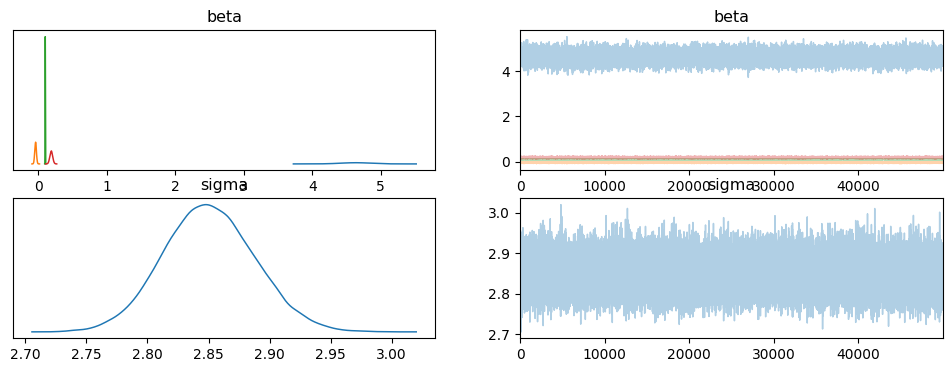

In [28]:
az.plot_trace(inference_data)

In [25]:
# Evaluating the model using the testing data
posterior_samples = mcmc.get_samples()
predictive = Predictive(model, posterior_samples)
predictions = predictive(X_test_with_intercept)

In [26]:
# Evaluating the model performance
predicted_mean = predictions['obs'].mean(axis=0).numpy()

mae = mean_absolute_error(y_test.numpy(), predicted_mean)
mse = mean_squared_error(y_test.numpy(), predicted_mean)
rmse = np.sqrt(mse)
r2 = r2_score(y_test.numpy(), predicted_mean)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

MAE: 2.574248790740967
MSE: 8.771841049194336
RMSE: 2.9617292881011963
R-squared: 0.4142488452511638


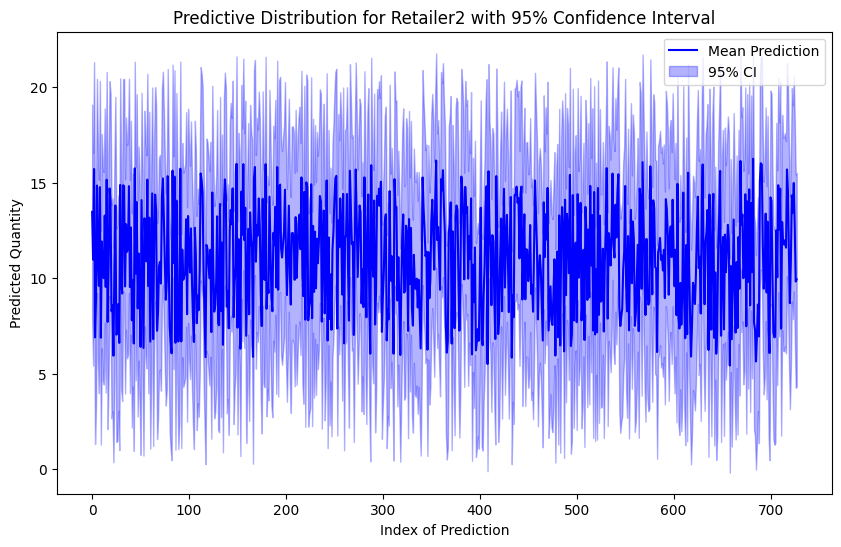

In [29]:
predicted_quantities = predictions["obs"].detach().numpy()

# Calculate the mean prediction and percentiles for confidence intervals
mean_prediction = np.mean(predicted_quantities, axis=0)
lower_bound = np.percentile(predicted_quantities, 2.5, axis=0)
upper_bound = np.percentile(predicted_quantities, 97.5, axis=0)

# Plot the predictive distribution with confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(mean_prediction, label="Mean Prediction", color="blue")
plt.fill_between(range(len(mean_prediction)), lower_bound, upper_bound, color="blue", alpha=0.3, label="95% CI")
plt.xlabel("Index of Prediction")
plt.ylabel("Predicted Quantity")
plt.title("Predictive Distribution for Retailer2 with 95% Confidence Interval")
plt.legend()
plt.show()

In [30]:
pred_df = pd.DataFrame({'Actual': np.array(y_test), 'Predicted': predicted_mean})
pred_df.head(10)

,Actual,Predicted
0,14.012052,13.468490
1,11.361376,10.973419
2,11.866525,15.712475
3,7.582064,6.900801
4,12.660746,8.914529
5,19.003220,14.846159
6,7.531439,11.054502
7,5.925906,9.591640
8,17.849398,14.759808
9,8.250834,6.882426


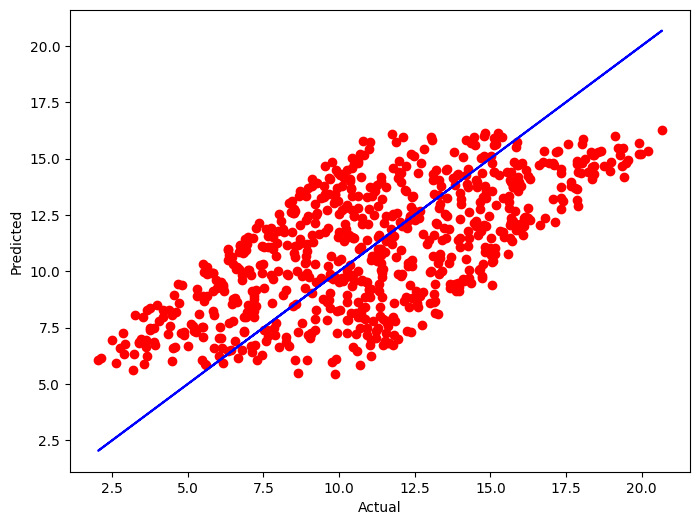

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(x=y_test, y=predicted_mean, color='r')
plt.plot(y_test, y_test, color='b')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()